# Thrills & Mysteries - Book Recommender System

Course: DATSCI 507: Data Science and Analytics using Python
Name : Sai Sneha Siddapura Venkataramappa
uniqname: saisneha

## Notebook 1: Data Preparation & Exploratory Data Analysis

This notebook handles:
1. Data loading and cleaning
2. Exploratory data analysis
3. Train-test split
4. Saving processed data for later notebooks

In [2]:
import os
import gc
import pickle
import warnings
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


print("Imports successful")

Imports successful


In [3]:
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
CHECKPOINTS_DIR = BASE_DIR / "checkpoints"
GRAPHS_DIR = BASE_DIR / "graphs"

# Create directories
for dir_path in [RAW_DIR, PROCESSED_DIR, CHECKPOINTS_DIR, GRAPHS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("Directory structure created")
print(f"Base: {BASE_DIR}")
print(f"Checkpoints: {CHECKPOINTS_DIR}")

Directory structure created
Base: /content
Checkpoints: /content/checkpoints


# Loading Data

In [4]:
print("\nLoading Goodreads dataset from Hugging Face...")
dataset_name = "euclaise/goodreads_100k"
print(f"Dataset: {dataset_name}")

# Load dataset
raw = load_dataset(dataset_name, split="train")
df = pd.DataFrame(raw)

# Standardize schema
print("\nStandardizing column names...")
rename_map = {
    "author": "author",
    "desc": "description",
    "genre": "genres",
    "isbn": "isbn",
    "rating": "rating",
    "reviews": "reviews",
    "title": "title",
    "totalratings": "num_ratings",
}

df = df[list(rename_map.keys())].rename(columns=rename_map)

print(f"✓ Dataset loaded: {df.shape[0]:,} books")
print(f"  Columns: {df.columns.tolist()}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Clear raw dataset from memory
del raw
gc.collect()


Loading Goodreads dataset from Hugging Face...
Dataset: euclaise/goodreads_100k


README.md:   0%|          | 0.00/791 [00:00<?, ?B/s]

data/train-00000-of-00001-624449314096eb(…):   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]


Standardizing column names...
✓ Dataset loaded: 100,000 books
  Columns: ['author', 'description', 'genres', 'isbn', 'rating', 'reviews', 'title', 'num_ratings']
  Memory usage: 149.31 MB


30

# Initial Data Analysis

In [5]:
# Basic info
print(f"\nDataset shape: {df.shape}")


Dataset shape: (100000, 8)


In [6]:
# Data types
print("\nData types:")
print(df.dtypes)


Data types:
author          object
description     object
genres          object
isbn            object
rating         float64
reviews          int64
title           object
num_ratings      int64
dtype: object


In [7]:
# Missing values
print("\nMissing values per column:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Missing', ascending=False)
print(missing_df[missing_df['Missing'] > 0])


Missing values per column:
             Missing  Percentage
isbn           14482       14.48
genres         10467       10.47
description     6772        6.77
title              1        0.00


In [8]:
# Sample rows
print("\nFirst 3 rows:")
print(df[['title', 'author', 'genres', 'rating']].head(3))


First 3 rows:
                                               title  \
0  Between Two Fires: American Indians in the Civ...   
1                           Fashion Sourcebook 1920s   
2                                         Hungary 56   

                             author  \
0              Laurence M. Hauptman   
1  Charlotte Fiell,Emmanuelle Dirix   
2                     Andy Anderson   

                                              genres  rating  
0  History,Military History,Civil War,American Hi...    3.52  
1          Couture,Fashion,Historical,Art,Nonfiction    4.51  
2                                   Politics,History    4.15  


In [9]:
# Rating statistics
print("\nRating statistics:")
print(df['rating'].describe())


Rating statistics:
count    100000.000000
mean          3.833055
std           0.621237
min           0.000000
25%           3.660000
50%           3.910000
75%           4.140000
max           5.000000
Name: rating, dtype: float64


In [10]:
print("\nNumber of ratings statistics:")
print(df['num_ratings'].describe())


Number of ratings statistics:
count    1.000000e+05
mean     2.990764e+03
std      3.635338e+04
min      0.000000e+00
25%      3.100000e+01
50%      1.460000e+02
75%      7.440000e+02
max      3.819326e+06
Name: num_ratings, dtype: float64


# Genre Analysis

Processing all genres...
  Processed 50,000 / 100,000 books...

 Total unique genres: 1182

Top 20 genres:
Romance                34324
Fantasy                30798
Fiction                29743
Nonfiction             29446
Historical             18183
Childrens              17304
History                15477
Cultural               14640
Sequential Art         13687
Mystery                13385
Religion               12323
Literature             11422
Paranormal             10748
Science                10676
Science Fiction        10568
Young Adult            10337
Contemporary            8809
European Literature     7773
Historical Fiction      7618
Comics                  7606
dtype: int64
Saved: /content/graphs/top_genres_full.png


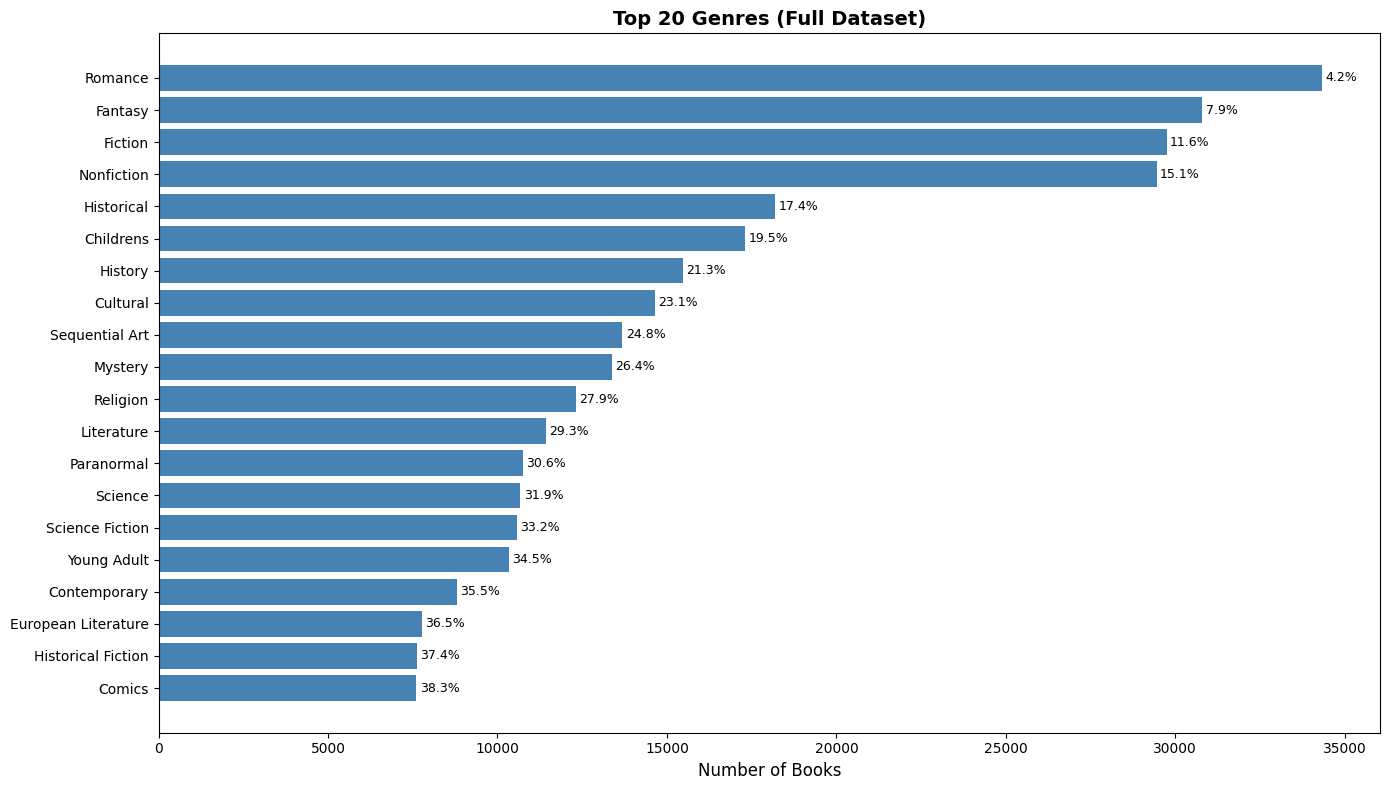

In [12]:
def process_genres_in_chunks(series, chunk_size=10000):
    genre_counter = Counter()

    for i in range(0, len(series), chunk_size):
        chunk = series.iloc[i:i+chunk_size]
        chunk_genres = chunk.dropna().apply(lambda x: [g.strip() for g in str(x).split(",")])
        for genres_list in chunk_genres:
            genre_counter.update(genres_list)

        if i % 50000 == 0 and i > 0:
            print(f"  Processed {i:,} / {len(series):,} books...")

    return genre_counter

print("Processing all genres...")
genre_counts = process_genres_in_chunks(df['genres'])
genre_counts_series = pd.Series(dict(genre_counts)).sort_values(ascending=False)

print(f"\n Total unique genres: {len(genre_counts_series)}")
print(f"\nTop 20 genres:")
print(genre_counts_series.head(20))

# Visualizing top genres
top_n = 20
top_genres = genre_counts_series[:top_n]
cumulative_pct = top_genres.cumsum() / genre_counts_series.sum() * 100

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.barh(range(len(top_genres)), top_genres.values, color='steelblue')
ax.set_yticks(range(len(top_genres)))
ax.set_yticklabels(top_genres.index)
ax.invert_yaxis()
ax.set_xlabel('Number of Books', fontsize=12)
ax.set_title(f'Top {top_n} Genres (Full Dataset)', fontsize=14, fontweight='bold')

# Adding percentage labels
for i, (count, pct) in enumerate(zip(top_genres.values, cumulative_pct)):
    ax.text(count + 100, i, f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(GRAPHS_DIR / 'top_genres_full.png', dpi=300, bbox_inches='tight')
print(f"Saved: {GRAPHS_DIR / 'top_genres_full.png'}")
plt.show()
plt.close()

# Mysteries and Thrillers Subset

In [13]:
mystery_keywords = [
    "Mystery", "Thriller", "Crime", "Detective", "Suspense",
    "Noir", "Psychological Thriller", "Cozy Mystery", "Murder Mystery",
    "Legal Thriller", "Spy Thriller", "Techno-Thriller"
]

pattern = "|".join(mystery_keywords)
df_mt = df[df['genres'].str.contains(pattern, case=False, na=False)].copy()
df_mt.reset_index(drop=True, inplace=True)

print(f"\nFiltered to Mystery & Thriller: {df_mt.shape[0]:,} books")
print(f"Percentage of full dataset: {len(df_mt)/len(df)*100:.2f}%")

# Show some statistics
print(f"\nFiltered dataset statistics:")
print(f"  Average rating: {df_mt['rating'].mean():.2f}")
print(f"  Median num_ratings: {df_mt['num_ratings'].median():.0f}")
print(f"  Books with 1000+ ratings: {(df_mt['num_ratings'] >= 1000).sum():,}")

# Clear original dataframe
del df
gc.collect()


Filtered to Mystery & Thriller: 9,088 books
Percentage of full dataset: 9.09%

Filtered dataset statistics:
  Average rating: 3.86
  Median num_ratings: 1222
  Books with 1000+ ratings: 4,966


15568

# EDA on Mysteries and Thrillers Subset

In [14]:
# Description statistics

print("Calculating description lengths...")
df_mt['desc_length'] = df_mt['description'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

print("\nDescription length statistics:")
print(df_mt['desc_length'].describe())

Calculating description lengths...

Description length statistics:
count    9088.000000
mean      858.064151
std       483.579627
min         0.000000
25%       541.000000
50%       803.000000
75%      1094.000000
max      4842.000000
Name: desc_length, dtype: float64


In [15]:
# Check for missing/empty descriptions

missing_desc = df_mt['description'].isnull().sum()
empty_desc = (df_mt['description'].astype(str).str.strip() == '').sum()
print(f"\nMissing descriptions: {missing_desc} ({missing_desc/len(df_mt)*100:.2f}%)")
print(f"Empty descriptions: {empty_desc} ({empty_desc/len(df_mt)*100:.2f}%)")



Missing descriptions: 127 (1.40%)
Empty descriptions: 0 (0.00%)


Saved: /content/graphs/description_lengths_mt.png


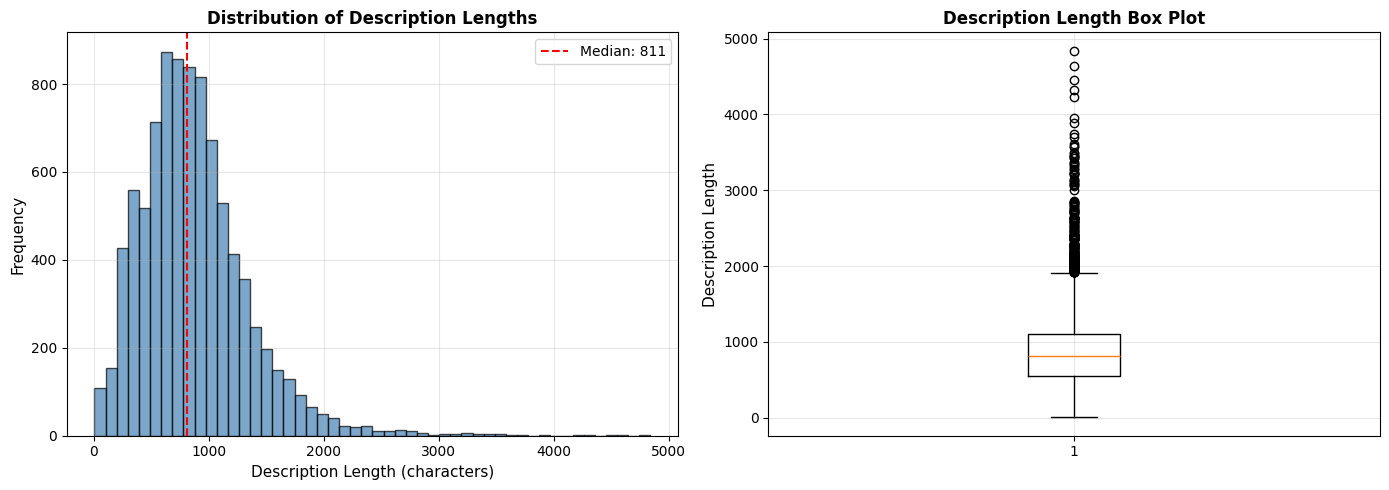

In [16]:
# Visualizing description lengths
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
valid_lengths = df_mt[df_mt['desc_length'] > 0]['desc_length']
axes[0].hist(valid_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Description Length (characters)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Description Lengths', fontsize=12, fontweight='bold')
axes[0].axvline(valid_lengths.median(), color='red', linestyle='--',
                label=f'Median: {valid_lengths.median():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(valid_lengths, vert=True)
axes[1].set_ylabel('Description Length', fontsize=11)
axes[1].set_title('Description Length Box Plot', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPHS_DIR / 'description_lengths_mt.png', dpi=300, bbox_inches='tight')
print(f"Saved: {GRAPHS_DIR / 'description_lengths_mt.png'}")
plt.show()
plt.close()

In [17]:
# Check for duplicates

duplicates = df_mt['title'].duplicated().sum()
print(f"\nDuplicate titles: {duplicates}")

# Rating distribution
print("\nRating distribution:")
print(df_mt['rating'].value_counts().sort_index())


Duplicate titles: 195

Rating distribution:
rating
2.23    1
2.43    1
2.54    1
2.61    1
2.62    1
       ..
4.62    3
4.63    3
4.67    1
4.75    1
5.00    4
Name: count, Length: 196, dtype: int64


# Data Cleaning

In [18]:
# Filtering duplicates, invalid descriptions or lengths

MIN_DESC_LENGTH = 50
MIN_NUM_RATINGS = 10  # Filter for books with some popularity

print(f"\nCleaning criteria:")
print(f"  - Remove duplicates")
print(f"  - Remove missing/empty descriptions")
print(f"  - Keep only descriptions >= {MIN_DESC_LENGTH} characters")
print(f"  - Keep only books with >= {MIN_NUM_RATINGS} ratings")

initial_count = len(df_mt)

# Remove duplicates
before_dup = len(df_mt)
df_mt = df_mt.drop_duplicates(subset='title').copy()
print(f"  Removed {before_dup - len(df_mt)} duplicates")

# Remove missing/empty descriptions
df_mt = df_mt[df_mt['description'].notnull()].copy()
df_mt = df_mt[df_mt['description'].astype(str).str.strip() != ''].copy()
print(f"  After removing empty descriptions: {len(df_mt):,} books")

# Remove short descriptions
df_mt = df_mt[df_mt['description'].astype(str).str.len() >= MIN_DESC_LENGTH].copy()
print(f"  After removing short descriptions: {len(df_mt):,} books")

# Filter by number of ratings (quality control)
df_mt = df_mt[df_mt['num_ratings'] >= MIN_NUM_RATINGS].copy()
print(f"  After filtering by num_ratings: {len(df_mt):,} books")


Cleaning criteria:
  - Remove duplicates
  - Remove missing/empty descriptions
  - Keep only descriptions >= 50 characters
  - Keep only books with >= 10 ratings
  Removed 195 duplicates
  After removing empty descriptions: 8,766 books
  After removing short descriptions: 8,741 books
  After filtering by num_ratings: 8,730 books


In [19]:
import re

print(f"Starting with df_mt: {len(df_mt)} mystery/thriller books")

def is_english_text(text):
    """Quick English detection"""
    if pd.isna(text) or not isinstance(text, str):
        return False

    text = str(text).strip()
    if len(text) < 30:
        return False

    text_lower = text.lower()
    words = re.findall(r'\b[a-z]+\b', text_lower)

    if len(words) < 5:
        return False

    # Non-English indicators
    non_english = ['el', 'la', 'los', 'las', 'que', 'del', 'le', 'les', 'un', 'une',
                   'der', 'die', 'das', 'und', 'di', 'che', 'il', 'och', 'det', 'att',
                   'og', 'en', 'er', 'się', 'nie', 'jest']

    sample_words = words[:100]
    non_english_count = sum(1 for word in sample_words if word in non_english)
    non_english_ratio = non_english_count / len(sample_words) if len(sample_words) > 0 else 0

    if non_english_ratio > 0.15:
        return False

    # English indicators
    common_english = {'the', 'a', 'and', 'to', 'of', 'in', 'is', 'was', 'for', 'with',
                     'he', 'she', 'his', 'her', 'that', 'this', 'are', 'were', 'been'}

    english_count = sum(1 for word in sample_words if word in common_english)
    english_ratio = english_count / len(sample_words) if len(sample_words) > 0 else 0

    return english_ratio > 0.20

# Apply filter
df_mt['is_english'] = df_mt['description'].apply(is_english_text)

# Show what's being filtered
english_count = df_mt['is_english'].sum()
non_english_count = len(df_mt) - english_count

print(f"\nLanguage detection results:")
print(f"  English: {english_count} ({english_count/len(df_mt)*100:.1f}%)")
print(f"  Non-English: {non_english_count} ({non_english_count/len(df_mt)*100:.1f}%)")

if non_english_count > 0:
    print(f"\nSample non-English books being removed:")
    for idx, row in df_mt[~df_mt['is_english']].head(3).iterrows():
        print(f"  • {row['title']}")
        print(f"    {str(row['description'])[:80]}...")

# Filter to English only
df_mt = df_mt[df_mt['is_english']].copy()
df_mt = df_mt.drop(columns=['is_english'])

print(f"\n Filtered df_mt to English-only: {len(df_mt)} books")
print(f"  Removed: {non_english_count} non-English books")

# Reset index
df_mt = df_mt.reset_index(drop=True)

Starting with df_mt: 8730 mystery/thriller books

Language detection results:
  English: 7772 (89.0%)
  Non-English: 958 (11.0%)

Sample non-English books being removed:
  • Alting har sin pris
    PÃ¥ den grÃ¸nlandske indlandsis finder en miljÃ¸delegation et over femogtyve Ã¥r...
  • Polskie morderczynie
    Ich procesy relacjonowaÅ‚y wszystkie media w Polsce. WykreowaÅ‚y wizerunek zÅ‚yc...
  • Tylko martwi nie kÅ‚amiÄ…
    Profiler policyjny musi rozwikÅ‚aÄ‡ zagadkÄ™ Å›mierci Å›mieciowego barona, ktÃ³r...

 Filtered df_mt to English-only: 7772 books
  Removed: 958 non-English books


In [20]:
# Cleaning Text

import re

def normalize_text(text):
    """Normalize text: lowercase, remove punctuation, collapse spaces"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # keeping alphanumeric + spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text normalization in batches
print("\nNormalizing text descriptions")
BATCH_SIZE = 5000
clean_descs = []

for i in range(0, len(df_mt), BATCH_SIZE):
    batch = df_mt['description'].iloc[i:i+BATCH_SIZE]
    clean_batch = batch.apply(normalize_text)
    clean_descs.extend(clean_batch.tolist())

    if (i + BATCH_SIZE) % 20000 == 0:
        print(f"  Processed {min(i + BATCH_SIZE, len(df_mt)):,} / {len(df_mt):,}")
        gc.collect()

df_mt['clean_desc'] = clean_descs


Normalizing text descriptions


In [21]:
# Remove entries with very few alphabetic characters
df_mt = df_mt[df_mt['clean_desc'].str.count(r'[a-z]') >= 20].copy()
df_mt.reset_index(drop=True, inplace=True)

print(f"\n✓ Cleaned dataset: {len(df_mt):,} books")
print(f"  Reduction: {(1 - len(df_mt)/initial_count)*100:.1f}%")

# Update description length
df_mt['desc_length'] = df_mt['clean_desc'].str.len()

gc.collect()


✓ Cleaned dataset: 7,772 books
  Reduction: 14.5%


59

# Distribution Analysis in Filtered and Cleaned Dataset

Processing M&T genres...

Top 15 genres in M&T subset:
Mystery               11567
Fiction                6018
Thriller               5235
Romance                5133
Fantasy                4294
Crime                  3420
Historical             3165
Mystery Thriller       2215
Suspense               2184
Contemporary           1709
Paranormal             1702
Audiobook              1561
Science Fiction        1519
Historical Fiction     1469
Young Adult            1379
dtype: int64
Saved: /content/graphs/top_genres_mt.png


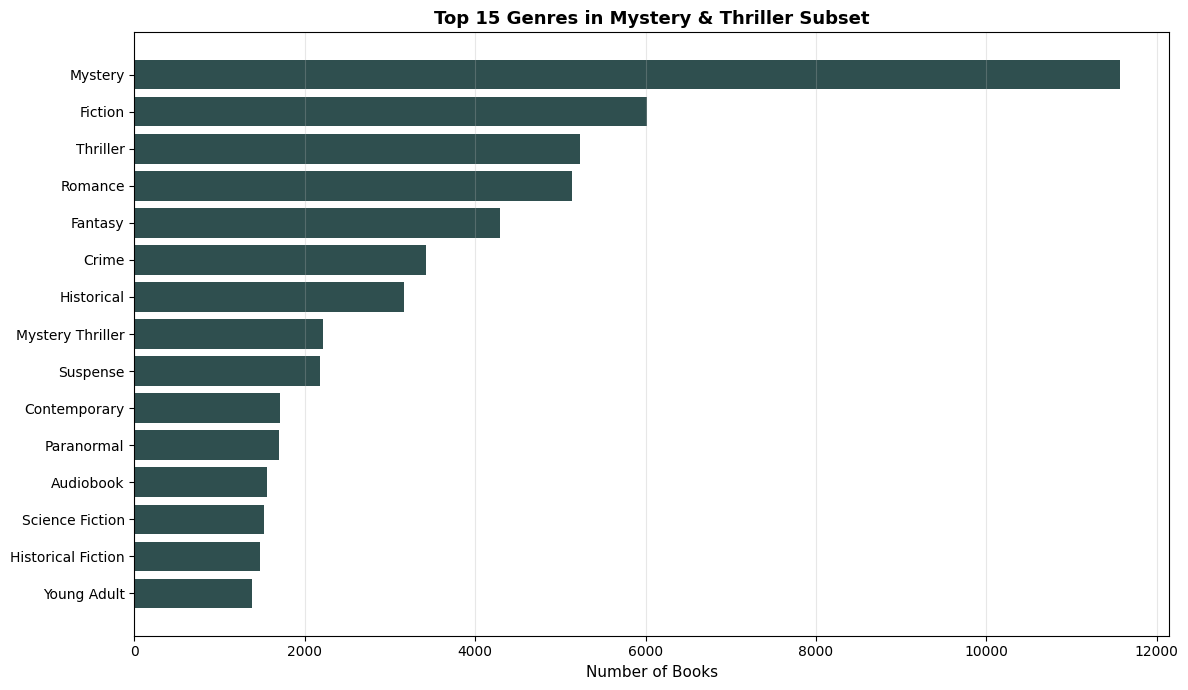

In [22]:
# Parse genres for filtered data (in chunks)
print("Processing M&T genres...")
mt_genre_counts = process_genres_in_chunks(df_mt['genres'], chunk_size=5000)
mt_genre_series = pd.Series(dict(mt_genre_counts)).sort_values(ascending=False)

print(f"\nTop 15 genres in M&T subset:")
print(mt_genre_series.head(15))

# Visualizing
fig, ax = plt.subplots(figsize=(12, 7))
top_mt = mt_genre_series.head(15)
ax.barh(range(len(top_mt)), top_mt.values, color='darkslategray')
ax.set_yticks(range(len(top_mt)))
ax.set_yticklabels(top_mt.index)
ax.invert_yaxis()
ax.set_xlabel('Number of Books', fontsize=11)
ax.set_title('Top 15 Genres in Mystery & Thriller Subset', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPHS_DIR / 'top_genres_mt.png', dpi=300, bbox_inches='tight')
print(f"Saved: {GRAPHS_DIR / 'top_genres_mt.png'}")
plt.show()
plt.close()

# Rating Analysis

Saved: /content/graphs/rating_analysis_mt.png


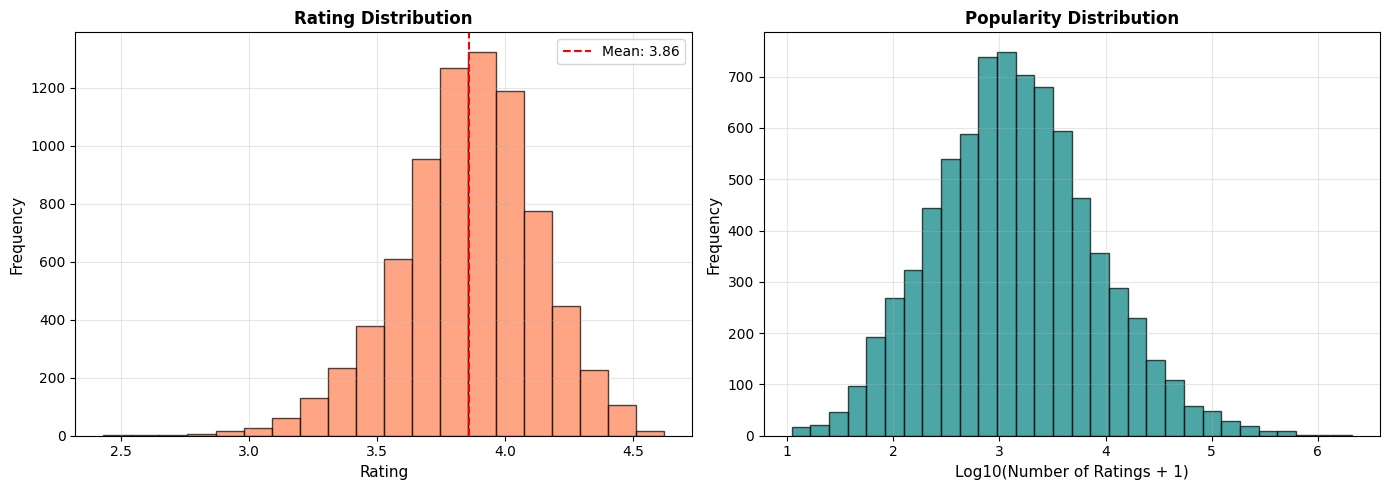

In [23]:
# Rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating histogram
axes[0].hist(df_mt['rating'], bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Rating', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Rating Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(df_mt['rating'].mean(), color='red', linestyle='--',
                label=f'Mean: {df_mt["rating"].mean():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Number of ratings (log scale)
axes[1].hist(np.log10(df_mt['num_ratings'] + 1), bins=30, color='teal', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log10(Number of Ratings + 1)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Popularity Distribution', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPHS_DIR / 'rating_analysis_mt.png', dpi=300, bbox_inches='tight')
print(f"Saved: {GRAPHS_DIR / 'rating_analysis_mt.png'}")
plt.show()
plt.close()

# Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using 7,772 sampled descriptions...


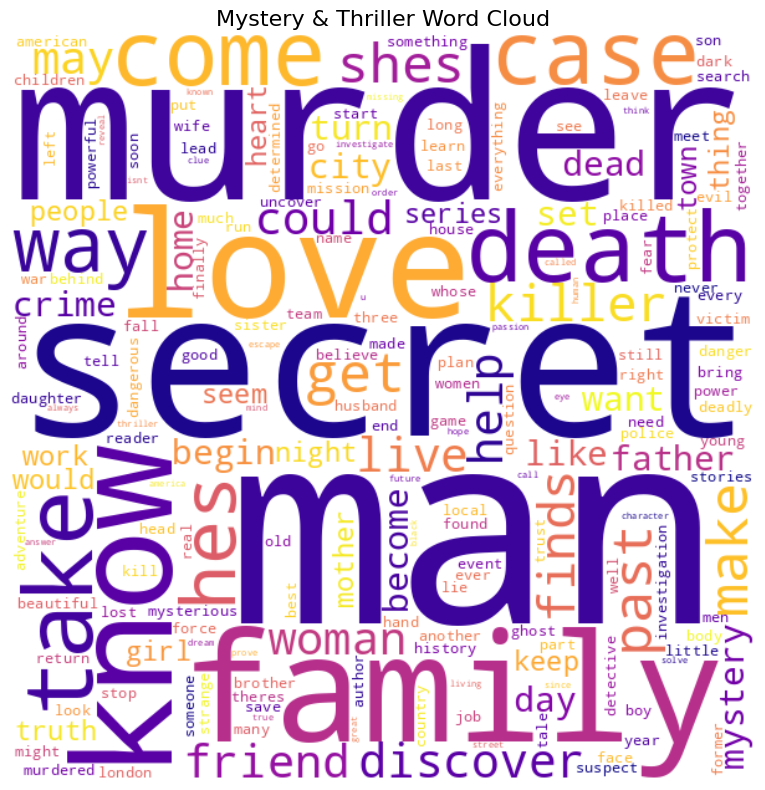

In [24]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Dynamically get stopwords for English
stop_words = set(stopwords.words('english'))

# Additional custom stopwords (common filler words) that are not handled by NLTK
custom_stopwords = set([
    'book', 'novel', 'story', 'will', 'one', 'new', 'first',
    'time', 'back', 'life', 'world', 'must', 'find', 'two',
    'nothing', 'yet', 'also', 'even', 'so', 'but', 'that', 'about',
    "new", "york", "times"
])

# Combine the NLTK stopwords with the custom stopwords
stop_words.update(custom_stopwords)

# Sample descriptions from the dataframe
SAMPLE_SIZE = min(10000, len(df_mt))  # Adjust based on your data size
sampled_descs = df_mt['clean_desc'].sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED)
text = " ".join(sampled_descs.tolist())

# Display how many descriptions are being sampled
print(f"Using {SAMPLE_SIZE:,} sampled descriptions...")

# Create the word cloud, excluding stopwords
try:
    wc = WordCloud(
        width=600,
        height=600,
        background_color="white",
        colormap="plasma",
        contour_color='steelblue',
        contour_width=2,
        max_words=200,
        stopwords=stop_words,
        random_state=RANDOM_SEED
    ).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Mystery & Thriller Word Cloud", fontsize=16)
    plt.tight_layout()

    # Save and display the word cloud
    plt.savefig(GRAPHS_DIR / "wordcloud_mt.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Clean up
    del wc

except Exception as e:
    print(f"Word cloud generation failed: {e}")


# Train - Test Split

In [26]:
df_train, df_test = train_test_split(
    df_mt,
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"\nTrain set: {len(df_train):,} books ({len(df_train)/len(df_mt)*100:.1f}%)")
print(f"Test set:  {len(df_test):,} books ({len(df_test)/len(df_mt)*100:.1f}%)")



Train set: 6,217 books (80.0%)
Test set:  1,555 books (20.0%)


In [27]:
def parse_genres(genre_str):
    """Parse genre string into list"""
    if pd.isna(genre_str):
        return []
    return [g.strip() for g in str(genre_str).split(',')]

# Parse genres
print("Parsing genres for train set...")
df_train['genres'] = df_train['genres'].apply(parse_genres)

print("Parsing genres for test set...")
df_test['genres'] = df_test['genres'].apply(parse_genres)

print("Genres parsed as lists")

Parsing genres for train set...
Parsing genres for test set...
Genres parsed as lists


In [ ]:
# Saving checkpoints for next notebook

In [28]:
checkpoint_cols = ['title', 'author', 'description', 'clean_desc', 'genres',
                   'desc_length', 'rating', 'num_ratings', 'reviews', 'isbn']
existing_cols = [col for col in checkpoint_cols if col in df_train.columns]

# Select only needed columns
df_train_save = df_train[existing_cols].copy()
df_test_save = df_test[existing_cols].copy()
df_mt_save = df_mt[existing_cols].copy()

checkpoint_1 = {
    'df_mt': df_mt_save,
    'df_train': df_train_save,
    'df_test': df_test_save,
    'metadata': {
        'total_books': len(df_mt_save),
        'train_size': len(df_train_save),
        'test_size': len(df_test_save),
        'random_seed': RANDOM_SEED,
        'min_desc_length': MIN_DESC_LENGTH,
        'min_num_ratings': MIN_NUM_RATINGS,
        'target_genres': mystery_keywords,
        'dataset_source': 'euclaise/goodreads_100k'
    }
}

checkpoint_path = CHECKPOINTS_DIR / 'checkpoint_1_data_prepared.pkl'
print(f"Saving checkpoint to {checkpoint_path}...")

with open(checkpoint_path, 'wb') as f:
    pickle.dump(checkpoint_1, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved checkpoint: {checkpoint_path}")
print(f" Size: {checkpoint_path.stat().st_size / 1024**2:.2f} MB")

# Also save CSVs for easy inspection (sample only to save space)
SAMPLE_CSV = 1000
df_train_save.head(SAMPLE_CSV).to_csv(PROCESSED_DIR / 'train_data_sample.csv', index=False)
df_test_save.head(SAMPLE_CSV).to_csv(PROCESSED_DIR / 'test_data_sample.csv', index=False)
print(f"Saved sample CSVs (first {SAMPLE_CSV} rows): {PROCESSED_DIR}")

# Clear variables
del df_train_save, df_test_save, df_mt_save, checkpoint_1
gc.collect()

Saving checkpoint to /content/checkpoints/checkpoint_1_data_prepared.pkl...
Saved checkpoint: /content/checkpoints/checkpoint_1_data_prepared.pkl
 Size: 16.28 MB
Saved sample CSVs (first 1000 rows): /content/data/processed


8276

# Summary of notebook 1

In [29]:
summary_stats = {
    'Dataset source': 'euclaise/goodreads_100k',
    'Mystery & Thriller books': len(df_mt),
    'Train set': len(df_train),
    'Test set': len(df_test),
    'Avg rating': f"{df_mt['rating'].mean():.2f}",
    'Avg num_ratings': f"{df_mt['num_ratings'].mean():.0f}",
    'Avg description length': f"{df_mt['desc_length'].mean():.0f}",
    'Median description length': f"{df_mt['desc_length'].median():.0f}",
    'Unique genres': len(mt_genre_series),
    'Most common genre': mt_genre_series.index[0],
}

print("\nFinal Statistics:")
for key, value in summary_stats.items():
    print(f"  {key:.<40} {value}")


Final Statistics:
  Dataset source.......................... euclaise/goodreads_100k
  Mystery & Thriller books................ 7772
  Train set............................... 6217
  Test set................................ 1555
  Avg rating.............................. 3.86
  Avg num_ratings......................... 7858
  Avg description length.................. 847
  Median description length............... 790
  Unique genres........................... 751
  Most common genre....................... Mystery
